In [1]:
import pandas as pd
import numpy as np
import string
from nltk.stem.porter import PorterStemmer
import nltk
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_auc_score
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import seaborn as sns

## Class for Sentiment ML

In [2]:
class SentimentML_RandForest:
    
    def __init__(self):
        
        self.pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())])
        
        self.model = None
        nltk.download('stopwords')
        nltk.download('wordnet')
    
    
    def __contains_only_numb(self, word):
        numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        for a in word:
            if a not in numbers:
                return False
        return True

    def __remove_numb(self, word):
        numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        for a in word:
            if a in numbers:
                word = word.replace(a, '')
        return word

    def __clear_word(self, word):
        arr_en = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                  'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

        arr_EN = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                  'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

        numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

        for a in word:
            if (a not in arr_en) and (a not in arr_EN) and (a not in numbers):
                word = word.replace(a, '')
        return word
    
    def _preprocessing(self, df_data, train):
        
        df = df_data.copy()
        
        # replace " '" with "'"

        df['news'] = df['news'].apply(lambda x: x.lower().strip().replace(" '", "'"))
        df.head()

        # lower and remove punctuation

        remove_punctuation = string.punctuation

        df['news'] = df['news'].apply(lambda x: x.lower().strip().translate(str.maketrans('', '', remove_punctuation)))

        # spliting

        df['news'] = df['news'].apply(lambda x: x.split())

        # remove trash from words

        df['news'] = df['news'].apply(lambda x: [self.__clear_word(word) for word in x])

        # replace numbers to 'number'

        df['news'] = df['news'].apply(lambda x: [('number' if self.__contains_only_numb(word) else word) for word in x])

        # remove numbers from words

        df['news'] = df['news'].apply(lambda x: [self.__remove_numb(word) for word in x])

        # remove stopwords

        stopwords = nltk.corpus.stopwords.words('english')
        df['news'] = df['news'].apply(lambda x: [word for word in x if word not in stopwords])

        # remove 'nannan'

        df['news'] = df['news'].apply(lambda x: [word for word in x if word != 'nannan'])
        
        # stemming

        stemmer = PorterStemmer()
        df['news'] = df['news'].apply(lambda x: [stemmer.stem(word) for word in x])

        # replace urls with 'url'

        df['news'] = df['news'].apply(lambda x: [('url' if ('http' in word) else word) for word in x])

        if train == True:
            #remove frequent words

            cnt = Counter()
            for news in df["news"]:
                for word in news:
                    cnt[word] += 1

            self.FREQWORDS = set([w for (w, wc) in cnt.most_common(12)])
        
        df["news"] = df["news"].apply(lambda x: [word for word in x if word not in self.FREQWORDS])


        df.dropna(inplace = True)
        
        # join words
        
        df['news'] = df['news'].apply(lambda x: " ".join(x))

        return df
    
    def train(self, df_train_data):
        
        """
        You should firstly map targets to 0 and 1
        and have column 'news' in your dataframe
        """
        
        self._preprocessing(df_train_data, True)
        
        X_train = df_train_data['news']
        y_train = df_train_data['target']
        
        self.model = self.pipe.fit(X_train, y_train)
        
    def predict(self, df_data):
        
        """
        You should have column 'news' in your dataframe
        """
        
        self._preprocessing(df_data, False)
        X = df_data['news']
        
        return self.model.predict(X)
    
    def predict_proba(self, df_data):
        
        """
        You should have column 'news' in your dataframe
        """
        
        self._preprocessing(df_data, False)
        X = df_data['news']
        
        return self.model.predict_proba(X)


## Read data

In [5]:
# read data
df1 = pd.read_excel('./data/all-data1.xlsx', encoding = 'utf8')
df1.columns = ['emotion', 'text_1', 'text_2', 'text_3']
df1['news'] = df1['text_1'].astype(str) + df1['text_2'].astype(str) + df1['text_3'].astype(str)
df1.drop(['text_1', 'text_2', 'text_3'], axis = 1, inplace = True)
df1 = df1[df1['emotion'] != 'neutral']
df1['target'] = df1['emotion']
df1.drop('emotion', axis = 1, inplace = True)
# mapping of target
df1['target'] = df1['target'].map({'negative' : 0, 'positive' : 1})

print(df1.shape)
df1.head()

(1967, 2)


,news,target
1,The international electronic industry company ...,0
2,With the new production plant the company woul...,1
3,According to the company 's updated strategy f...,1
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
5,"For the last quarter of 2010 , Componenta 's n...",1


In [6]:
# read more data
df2 = pd.read_csv('./data/stock_data.csv', encoding = 'utf8')
df2.columns = ['news', 'target']
df2['target'] = pd.get_dummies(df2['target'].astype(str), drop_first= True)

print(df2.shape)
df2.head()

(5791, 2)


,news,target
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [7]:
# read one more data

df3 = pd.read_csv('./data/data.csv', names = ['t', 'news'])
df3['target'] = df3['t']
df3.drop('t', axis = 1, inplace = True)
df3.dropna(inplace = True)

print(df3.shape)
df3.head()

(687, 2)


,news,target
0,Microsoft has reached 44 million daily ac...,0
1,Investors have been grasping for some sort of ...,1
2,Shares in Publicis Groupe rose...,0
3,"“The store is just sick.”Oscar Quinones, 28, w...",0
4,Danaher is famous for its business system...,1


In [8]:
# and more

df4 = pd.read_csv('./data/tweets_labelled.csv', sep=';')
df4.drop(['id', 'created_at'], axis = 1, inplace = True)
df4.rename(columns = {'text' : 'news', 'sentiment' : 'target'}, inplace = True)
df4.dropna(axis = 0, inplace = True)
df4['target'] = df4['target'].map({'negative' : 0, 'positive' : 1})
df4 = df4[pd.notnull(df4['target'])]
df4['target'] = df4['target'].map({0.0 : 0, 1.0 : 1})

print(df4.shape)
df4.head()

(876, 2)


,news,target
0,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",1
1,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,0
2,Net issuance increases to fund fiscal programs...,1
3,RT @bentboolean: How much of Amazon's traffic ...,1
4,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,1


In [9]:
# last data frame with data

df5 = pd.read_csv('./data/tweet_sentiment.csv')
df5.dropna(inplace = True)
df5 = df5[df5['sentiment'] != 0]
df5['sentiment'] = df5['sentiment'].map({-1 : 0, 1 : 1})
df5.rename(columns = {'cleaned_tweets' : 'news', 'sentiment' : 'target'}, inplace = True)

print(df5.shape)
df5.head()

(11110, 2)


,news,target
2,say american dream dead,0
3,barri silbert extrem optimist bitcoin predict ...,1
4,satellit avoid attack space junk circl earth paid,0
8,senat want emerg alert go netflix spotifi etc,1
10,u propos expedit appeal fight amp time warner ...,0


In [10]:
# concat all data

df = pd.concat([df1, df2, df3, df4, df5])
print(df.shape)
df.head()

(20431, 2)


,news,target
1,The international electronic industry company ...,0
2,With the new production plant the company woul...,1
3,According to the company 's updated strategy f...,1
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
5,"For the last quarter of 2010 , Componenta 's n...",1


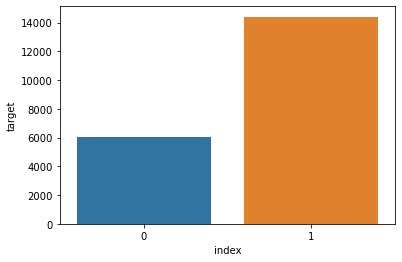

In [11]:
# distribution of classes

class_counts = df['target'].value_counts().to_frame().reset_index()
sns.barplot(y = class_counts['target'], x = class_counts['index'])

## Train model

In [12]:
df_train, df_test = train_test_split(
    df,
    test_size = 0.2,
    random_state = 0
)

SentimentML = SentimentML_RandForest()
SentimentML.train(df_train)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stalker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/stalker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Test data

In [13]:
y_test = df_test['target']
y_pred = SentimentML.predict(df_test)
y_pred_proba = SentimentML.predict_proba(df_test)

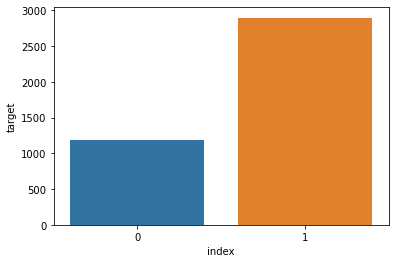

In [14]:
# real test data

real_class_counts_test = y_test.value_counts().to_frame().reset_index()
sns.barplot(y = real_class_counts_test['target'], x = real_class_counts_test['index'])

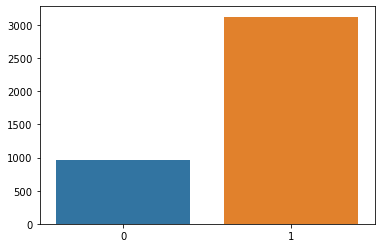

In [16]:
# predicted test data
unique, counts = np.unique(y_pred, return_counts = True)
print()
sns.barplot(y = counts, x = unique)

In [17]:
df_pred = pd.DataFrame()
df_pred['test'] = df_test['news']
df_pred['pred_targ'] = y_pred
df_pred['pred_prob_1'] = y_pred_proba[:,1]

df_pred.head(50)

,test,pred_targ,pred_prob_1
13123,cme max pain matur maxpain option,0,0.000000
4093,et's do this BVSN,1,0.670000
14584,rt longshot oil rich draw wildcatt utah desert...,1,1.000000
16361,get access premium paid group fraction price j...,1,1.000000
22292,rt citi semiconductor remain posit group long ...,1,0.940000
25630,rt bvtk phase complet press releas tell bvtk a...,1,0.990000
23199,newfield explor nfx lower hold zack invest res...,0,0.050000
4004,"In Finland , the city of Forssa has said it wi...",1,0.690000
16271,join us signal multipl paid group one join us ...,1,1.000000
18597,partial profit signal amp p also take partial ...,1,0.970000


In [18]:
print("RANDOM FOREST")

print()

print("accuracy score: {}%".format(round(accuracy_score(y_test, y_pred)*100,2)))
print("ROC_AUC: {}%".format(round(roc_auc_score(y_test, y_pred_proba[:,1])*100, 2)))
print()

print(classification_report(y_test, y_pred))

RANDOM FOREST

accuracy score: 87.64%
ROC_AUC: 94.55%

              precision    recall  f1-score   support

           0       0.86      0.69      0.77      1188
           1       0.88      0.95      0.92      2899

    accuracy                           0.88      4087
   macro avg       0.87      0.82      0.84      4087
weighted avg       0.87      0.88      0.87      4087



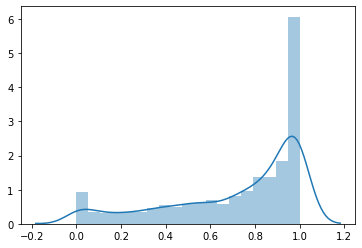

In [19]:
sns.distplot(y_pred_proba[:,1])

# One example to predict

In [20]:
news_amazon = """The average $ARKK holding is now 17.9% below its 50-day moving average.  Below are the ones farthest below their 50-DMAs and the two that are above $ICE and $NVS  Avg. $ARKK holding also down 10.95% over the last week."""

data = [[news_amazon, None]]
df_real = pd.DataFrame(data, columns = ['news', 'target'])

df_real.head()

df_real['target'] = SentimentML.predict(df_real)
df_real['prob_1'] = SentimentML.predict_proba(df_real)[:, 1]

df_real.head()

,news,target,prob_1
0,The average $ARKK holding is now 17.9% below i...,0,0.35


# Real Data

In [21]:
# read data to predict

df_to_pred = pd.read_excel('./data/AmazonNews.xlsx', encoding = 'utf8')
df_to_pred['news'] = df_to_pred['Заголовок новости']

remove_columns = ['Дата', 'Время', 'Заголовок новости', 'Unnamed: 3', 'Unnamed: 4',
                 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Matt Day (author)']

df_to_pred.drop(axis = 1, columns = remove_columns, inplace = True)
df_to_pred['target'] = np.nan
df_to_pred.head(31)

,news,target
0,Amazon Plans to Offer Telehealth Services to O...,NaN
1,"Who Helps Pay Amazon, Walmart and McDonald's W...",NaN
2,Amazon’s New Grocery Store Chain Is More Tradi...,NaN
3,"Why Amazon, Google, and Microsoft Are Designin...",NaN
4,Apple and Amazon Buy Into Push to Make India M...,NaN
5,Amazon Sued for Alleged Hiring Bias,NaN
6,Bezos-Backed Vegan Milk Startup in Chile Eyes ...,NaN
7,Amazon Spends $131 Million for Stake in Cargo ...,NaN
8,"Amazon Union Vote Hit By Conspiracy Theories, ...",NaN
9,"Amazon Opening Cashierless Store in London, Fi...",NaN


In [22]:
# predict real data

df_train = df

SentimentML = SentimentML_RandForest()
SentimentML.train(df_train)
df_to_pred['target'] = SentimentML.predict(df_to_pred)
df_to_pred['prob_of_1'] = SentimentML.predict_proba(df_to_pred)[:,1]

df_to_pred.to_csv("Amazon_pred.csv")

df_to_pred.head(31)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stalker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/stalker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,news,target,prob_of_1
0,Amazon Plans to Offer Telehealth Services to O...,1,0.80
1,"Who Helps Pay Amazon, Walmart and McDonald's W...",1,0.65
2,Amazon’s New Grocery Store Chain Is More Tradi...,1,0.83
3,"Why Amazon, Google, and Microsoft Are Designin...",1,0.64
4,Apple and Amazon Buy Into Push to Make India M...,1,0.76
5,Amazon Sued for Alleged Hiring Bias,1,0.95
6,Bezos-Backed Vegan Milk Startup in Chile Eyes ...,1,0.88
7,Amazon Spends $131 Million for Stake in Cargo ...,1,0.92
8,"Amazon Union Vote Hit By Conspiracy Theories, ...",1,0.71
9,"Amazon Opening Cashierless Store in London, Fi...",1,0.73


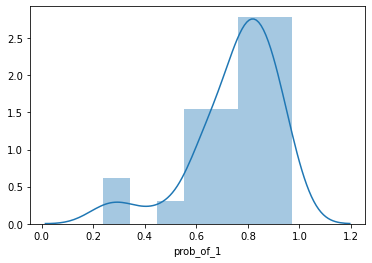

In [23]:
sns.distplot(df_to_pred['prob_of_1'])